## Strategy Comparison Across Stocks, ETFs, and Time Periods
This notebook is designed to compare multiple portfolio strategies across different stocks, ETFs, and time periods. Its goal is to help you identify which type of strategy best fits your investment style—whether you're aiming for growth, stability, or consistent revenue.

Keep in mind that some strategies include hyperparameters, which may cause variations in performance. We recommend exploring and tuning them thoughtfully.

Once you've identified a preferred strategy, you can move on to the 
- /examples/monthly_allocation.ipynb notebook or 
- execute optimize_my_portfolio.py 
to calculate your updated portfolio based on new capital.

In [21]:
# Import necessary libraries and modules
import sys
import os
import datetime

# Add parent directory to sys.path so you can import from data, strategies, evaluation, and backtesting modules
sys.path.append(os.path.abspath(".."))

from data import (
    DataLoader,
    build_cash_benchmark,
    build_rf_benchmark,
    build_spy_benchmark,
    build_custom_benchmark,
)

from backtesting import Backtester

from strategies import (
    MaxSharpeStrategy,
    MaxSortinoStrategy, 
    MomentumStrategy,
    RiskParityStrategy,
    EqualWeightStrategy,
    MeanVarianceOptimizationStrategy,
    BlackLittermanMVO,
    ValueAveragingStrategy,
    MinVarianceStrategy,
    CVaRStrategy,
    ValueOpportunityStrategy,
    DualMomentumStrategy,
    TrendFollowingStrategy,
    MeanReversionTrendStrategy,
    TimeSeriesMeanReversionStrategy
)
    

from evaluation import (
    plot_all_strategies_cumulative,
    plot_strategy,
    plot_drawdowns,
    plot_rolling_metrics,
    plot_risk_return_scatter,
    plot_time_weighted_returns,
    compute_strategy_metrics
)

import numpy as np
import pandas as pd

## 🧪 Backtesting a Portfolio Strategy: Setup

This section sets up the necessary components to backtest a portfolio strategy using a custom selection of assets.

- **Step 1:** Define your universe of stocks or ETFs. In this example, we use large-cap tech stocks.
- **Step 2:** Fetch historical price data using a custom `DataLoader` class. You can adjust the start date and frequency (e.g. monthly).
- **Step 3:** Specify the initial capital and how it's allocated across the assets.
- **Step 4:** Define how much new cash is added at each rebalancing period (e.g. monthly contributions).
- **Step 5:** Instantiate one or more strategies (e.g. Mean-Variance Optimization).
- **Step 6:** Run the backtest using the `Backtester`, which will simulate the portfolio evolution over time.

Once the backtest completes, you can analyze the results and compare strategy performance.

In [22]:
# 1a) Define your universe and fetch prices (incl. SPY for benchmark)
tickers = [
    # Standard
    "AMZN",     # Amazon
    #"META",     # Meta
    "GOOGL",     # Alphabet 
    "MSFT",     # Microsoft
    "TSM",      # TSMC
    #"NVDA",    # Nvidia (Unique case, ignore for evaluation)
    "AMD",     # AMD
    #WMT, MLI
    
    # Good performers
    #"NVDA",    # Nvidia (Unique case, ignore for evaluation)
    #"AAPL",     # Apple
    #"AMD",      # AMD
    #"MU",       # Micron
    #"TSM",      # TSMC ADR
    #"JPM",      # JPMorgan
    #"NBIS",     # Nebius Group (no historical data, ignore for evaluation)
    #"ANET",     # Arista Networks
    
    
    # Underperforming 
    #"INTC",       # Intel 
    #"BA",         # Boeing
    #"MA",         # Mastercard
    #"ADBE",       # Adobe
    #"VZ",         # Verizon
]


# tickers = [
#     "SPY", 
#     "SPMO",
#     "SMH"
# ]

# 1b) Load historical prices for the tickers
# You can adjust the start date and interval as needed
loader  = DataLoader(tickers, start='2022-01-01', interval='1mo')
prices = loader.fetch_prices()

# 2) Set up initial allocation: e.g. $x equally split across the n stocks
n = len(tickers)
initial_capital    = 0
initial_allocation = np.array([initial_capital / n] * n)

# 3) How much new cash to add each rebalance period?
monthly_cash = 1_000

# 4) Instantiate your strategies
strategies = {
    'EqualWeight': EqualWeightStrategy(tickers),
    'MVO':         MeanVarianceOptimizationStrategy(tickers, risk_aversion=1.0, lookback=3),
    'RiskParity':  RiskParityStrategy(tickers, lookback=7),
    'MaxSharpe':   MaxSharpeStrategy(tickers, lookback=3),
    'MaxSortino':  MaxSortinoStrategy(tickers, lookback=3),
    'Momentum':    MomentumStrategy(tickers, lookback=5, vol_threshold=0.4),
    'MomentumDiv': MomentumStrategy(tickers, lookback=5, vol_threshold=0.4, diversification=True),
    'MinVol':      MinVarianceStrategy(tickers),
    'BL':          BlackLittermanMVO(tickers, implied_weights=[1/n] * n),
    'CVaR':        CVaRStrategy(tickers, alpha=0.95),
    #'cvx':         CvxPortfolioStrategy(tickers),
    'ValueAvg':    ValueAveragingStrategy(tickers),
    'GPT':         ValueOpportunityStrategy(tickers, lookback_long=9, lookback_short=3, top_k=0.5),
    'DualMomentum': DualMomentumStrategy(tickers, lookback=12, top_fraction=0.3, weighting='equal'),
    'TrendFollowing': TrendFollowingStrategy(tickers, short_window=3, long_window=12),
    'MeanRevTrend': MeanReversionTrendStrategy(tickers,mean_reversion_lookback=6,skip_recent=0,top_n=3),
    'TimeSeriesMeanRev': TimeSeriesMeanReversionStrategy(tickers,mean_reversion_lookback=1,history_lookback=6,top_n=3)
}

# 5) Wire up and run the backtest
bt = Backtester(
    strategies         = strategies,
    prices             = prices,
    initial_allocation = initial_allocation,
    monthly_cash       = monthly_cash,
)

results = bt.run()

TypeError: 'module' object is not callable

## 📊 Creating Benchmark Portfolios

To evaluate your strategy's performance, it's important to compare it against various benchmark portfolios. This section sets up a few different types of benchmarks:

- **Cash benchmark:** Simulates simply saving the monthly contributions without any return.
- **Risk-free benchmark:** Models a savings account with interest (e.g. 1.25% annual rate).
- **Market benchmark (S&P 500):** Tracks the performance of investing in the SPY ETF with monthly contributions.
- **ETF benchmark (3-ETF strategy):** Diversifies contributions across multiple ETFs (e.g. SPY, QQQ, VYM).
- **Custom benchmark:** You can define your own mix of ETFs or stocks with custom weights to reflect your own investment approach.

All benchmarks assume the same cash flow: an initial capital and fixed monthly contributions. These are invested over time according to the benchmark's rules and weights.

The results are combined into a single DataFrame for easy comparison with your strategy's performance.

In [ ]:
## Create benchmarks

# Savings
dates = results['EqualWeight']['total_values'].index
cash_benchmark = build_cash_benchmark(dates, initial_capital, monthly_cash)

# Bank saving account with interest rate of 1.25% (risk-free rate as per ABN AMRO, 2025)
bank_benchmark = build_rf_benchmark(dates, initial_capital, monthly_cash, rf_rate=0.0125)

# S&P 500 benchmark 
spy_benchmark = build_spy_benchmark(dates, initial_capital, monthly_cash)

# ETF benchmark 
# 3 ETF strategy
# SPY: S&P 500 ETF   
# QQQ: Technlogy ETF 
# SMH: Semi-conductor ETF  
etfs = ['SPY', 'QQQ', 'SMH']
etf_benchmark = build_custom_benchmark(dates, initial_capital, monthly_cash, etfs, weights=[0.4, 0.3, 0.3])

tickers_dca = [
    "MSFT",   # Microsoft
    "AMZN",   # Amazon
    "GOOG",   # Alphabet (Class C)
    #"NVDA",   # Nvidia (Unique case, ignore for evaluation)
    "TSM",    # Taiwan Semiconductor
    #"ASML",   # ASML Holding
    #"AVGO",   # Broadcom
    "META",   # Meta Platforms
]
dca_benchmark = build_custom_benchmark(dates, initial_capital, monthly_cash, tickers_dca, weights=[1/len(tickers_dca)]*len(tickers_dca))
#
# You can build a custom benchmark with different ETFs or stocks to compare against
# Each monthly cash inflow is added to the benchmark portfolio based on the defined weights (e.g., 50% SPY, 40% QQQ, 10% VYM)
#

# Combine all benchmarks into a single DataFrame
benchmarks = pd.concat([cash_benchmark, bank_benchmark, spy_benchmark, etf_benchmark, dca_benchmark], axis=1)

## 📊 Strategy Evaluation & Performance Comparison

This section provides a comprehensive set of visualizations to evaluate and compare the performance of different portfolio strategies. Each plot highlights a different aspect of performance:

- **Cumulative Return Comparison**  
  `plot_all_strategies_cumulative(...)`  
  Compares the growth of different strategies over time, alongside benchmarks.

- **Time-Weighted Returns**  
  `plot_time_weighted_returns(...)`  
  Shows annualized and cumulative returns adjusted for the timing of cash flows.

- **Drawdowns**  
  `plot_drawdowns(...)`  
  Highlights the worst-performing periods (peak-to-trough losses) for each strategy, helping assess downside risk.

- **Rolling Performance Metrics**  
  `plot_rolling_metrics(...)`  
  Displays rolling Sharpe ratios, volatility, and return to show how performance evolves over time.

- **Risk-Return Scatter Plot**  
  `plot_risk_return_scatter(...)`  
  Visualizes the trade-off between risk (volatility) and return for each strategy in a single chart.

Use these plots to understand not just how much each strategy earns, but how consistently and with what level of risk.

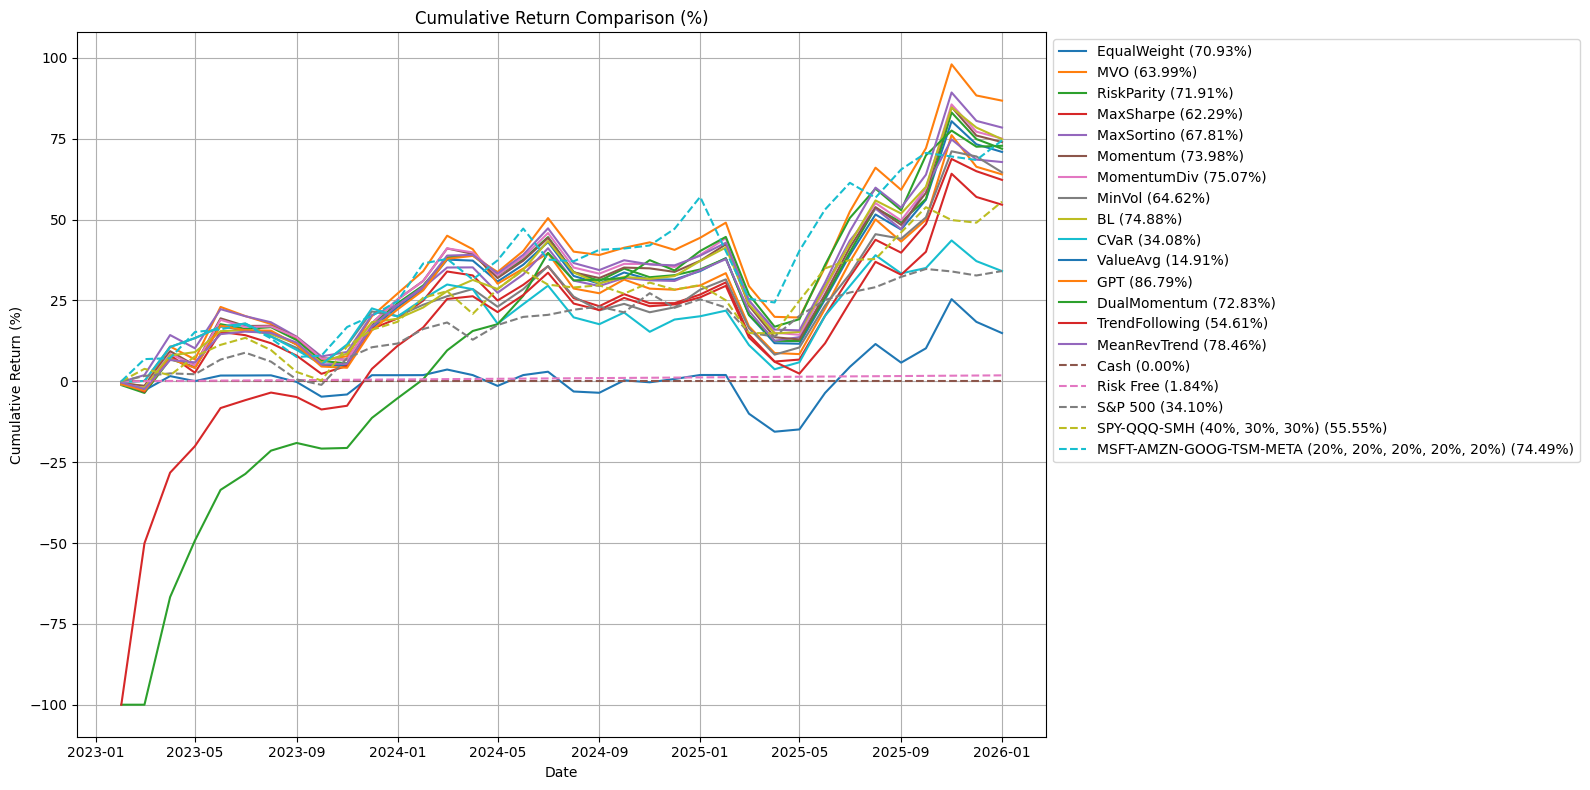

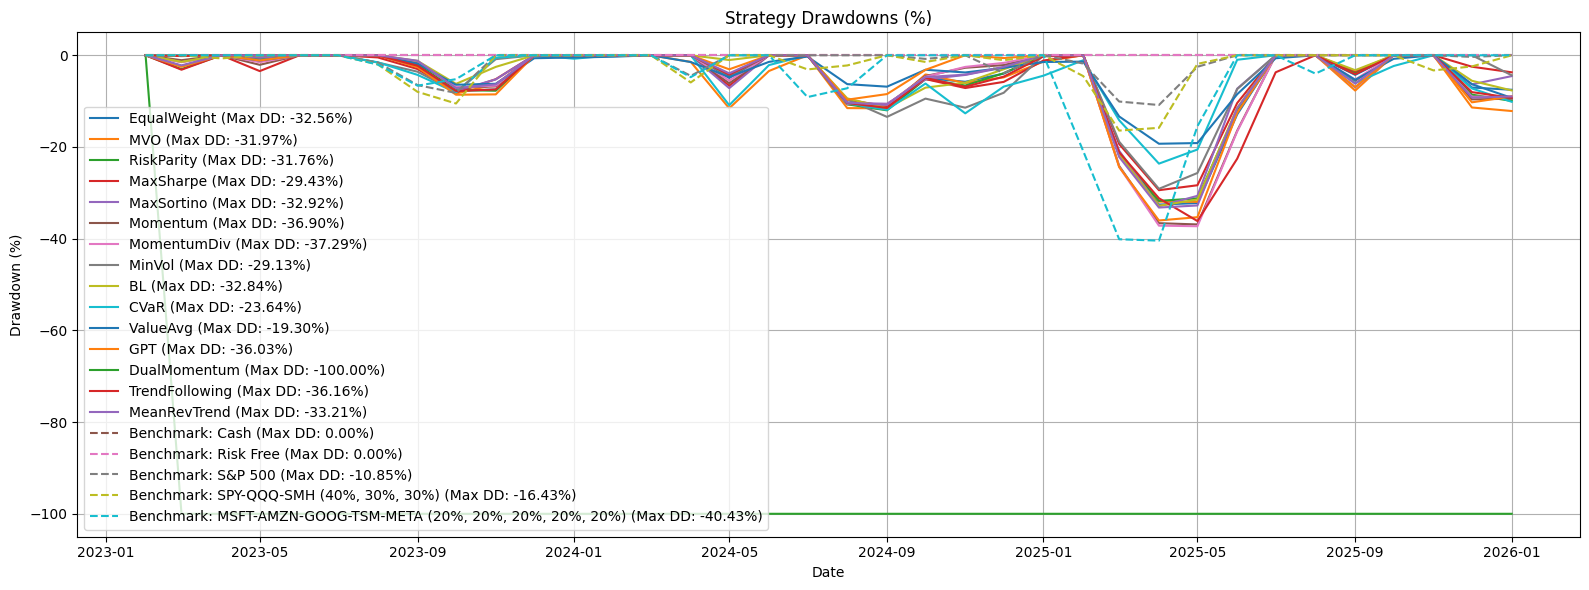

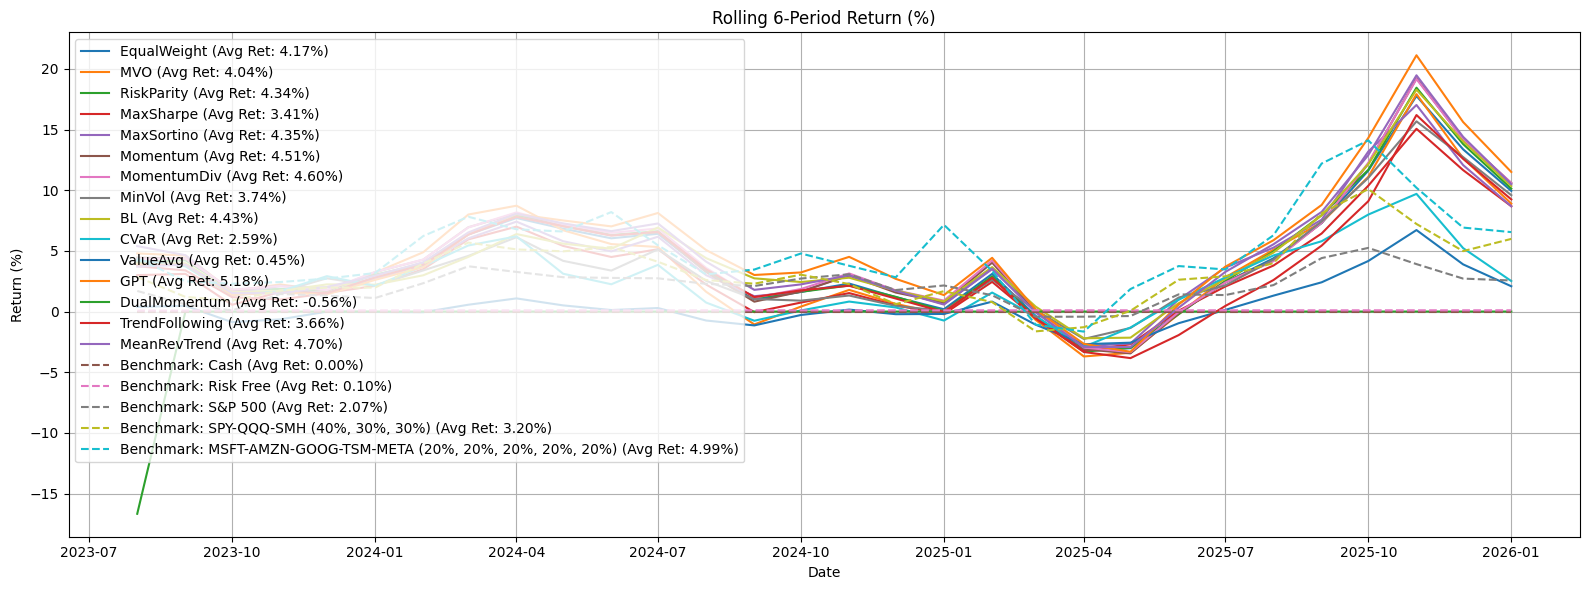

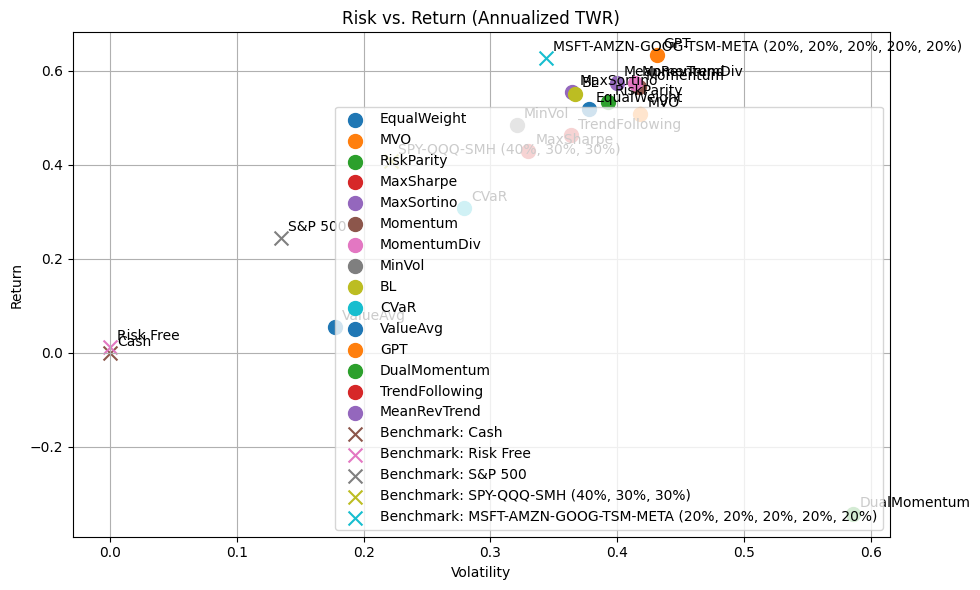

In [ ]:
# Graphing and evaluation
plot_all_strategies_cumulative(results, initial_capital, monthly_cash, benchmarks)
#plot_time_weighted_returns(results, monthly_cash, benchmarks)
plot_drawdowns(results, monthly_cash, benchmarks)
plot_rolling_metrics(results, monthly_cash, benchmarks)
plot_risk_return_scatter(results, monthly_cash, benchmarks)

In [ ]:
# To visualize the performance of individual strategies, uncomment the code below.
# For an example of how this works, see the notebook: run_single_strategy.ipynb

# for strategy_name, strategy_results in results.items():
#     plot_strategy(strategy_results, monthly_cash, benchmarks, title=strategy_name)

In [ ]:
# Compute and display strategy metrics
metrics_table = compute_strategy_metrics(results, monthly_cash=monthly_cash, benchmarks=benchmarks, risk_free_rate=0.0125, key_benchmark=spy_benchmark)
display(metrics_table)

,CAGR,Volatility,Downside Volatility,Sharpe,Sortino,Max Drawdown,Information Ratio
Name,,,,,,,
EqualWeight,0.3595,0.3775,0.0596,1.3411,2.4538,-0.3256,0.7633
MVO,0.3542,0.4183,0.0612,1.1859,2.3415,-0.3197,0.6615
RiskParity,0.3672,0.3926,0.0586,1.3267,2.5643,-0.3176,0.7645
MaxSharpe,0.3110,0.3298,0.0506,1.2651,2.3790,-0.2943,0.5973
MaxSortino,0.3782,0.3644,0.0615,1.4874,2.5428,-0.3292,0.9191
Momentum,0.3838,0.4172,0.0694,1.3260,2.3021,-0.3690,0.8123
MomentumDiv,0.3878,0.4139,0.0701,1.3556,2.3096,-0.3729,0.8403
MinVol,0.3412,0.3210,0.0538,1.4697,2.5318,-0.2913,0.7870
BL,0.3760,0.3665,0.0625,1.4677,2.4849,-0.3284,0.8766
